# Phase 1 Project

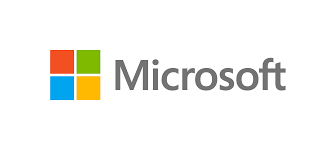

## Overview

## Business Problem

Microsoft has decided to open a new branch of their company: Microsoft Movie Studios. In order to aid the new head of Microsoft Movie Studios in making decisions regarding what type of films to create, I explore and analyze data from two sources: IMDb and Box Office Mojo. In doing so, I look at the ratings and lengths of various films, genres, production studios, and gross earnings.

## Data Understanding

In [1]:
#Importing neccesary packages
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import numpy as np
import plotly.express as px

In [4]:
test

NameError: name 'test' is not defined

In [2]:
#Loading in data from imdb file
conn = sqlite3.Connection('zippedData/im.db')

imdb_tables = """
SELECT name FROM sqlite_master WHERE type='table'
"""
pd.read_sql(imdb_tables, conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [3]:
#Loading in data from tmdb file
tmdb = pd.read_csv('./zippedData/tmdb.movies.csv.gz')

In [4]:
#Loading in data from the movie_gross file taken from Box Office Mojo
movie_gross_df = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')

### IMDb Data

In [5]:
#Looking at the number of rows (146144) and columns (6)
movie_basics_df = pd.read_sql("""SELECT * FROM movie_basics;""", conn)

In [6]:
#Looking at the general structure and content of the movie_basics table from the IMDb file
movie_basics_df.info()
#We have 6 columns and 146,144 rows with missing values in the following columns: 
#original_title, runtime_minutes, and genres

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [7]:
#Looking at the descriptive statistics for the numerical columns start_year and and runtime_minutes
movie_basics_df.describe()

#We see here that in the runtime_minutes column, both the min and max are outliers 
#with values of 1 and 51,420, respectively

#Furthermore, when disregarding the outliers, the range of movie runtimes is quite small 
#with the 25% quartile being 70 minutes and the 75% quartile being 99 minutes

#We also see that the max in the start_year column is an outlier as it is 2115 
#and suggests that we should analyze the column start_years in more depth

,start_year,runtime_minutes
count,146144.000000,114405.000000
mean,2014.621798,86.187247
std,2.733583,166.360590
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2015.000000,87.000000
75%,2017.000000,99.000000
max,2115.000000,51420.000000


In [8]:
#Looking at how many movies were released in each year
pd.read_sql("""
    SELECT COUNT(*) AS num_movies_per_year, start_year
    FROM movie_basics
    GROUP BY start_year;""", conn)

#This dataframe shows that some movies that have not been released yet (2023 and onward) are included in this dataset

#Therefore, in our data preparation, we will create a new table that includes 
#Only the movies that have already been released

,num_movies_per_year,start_year
0,11849,2010
1,12900,2011
2,13787,2012
3,14709,2013
4,15589,2014
5,16243,2015
6,17272,2016
7,17504,2017
8,16849,2018
9,8379,2019


In [9]:
#Looking at the average movie runtime in minutes per year
movie_basics_df.groupby('start_year').mean()

#This dataframe shows the mean runtime in minutes per year
#As we can see, length of movies have increased over time

#Furthermore, this dataframe confirms that we should remove the years 2023 - 2115 when we clean our data

,runtime_minutes
start_year,
2010,85.495694
2011,86.410106
2012,89.208856
2013,84.931670
2014,84.541500
2015,85.407108
2016,84.974249
2017,85.732214
2018,87.661099


In [10]:
#Looking at how many movies fall under specific genre categories (ex: how many movies are from the Drama genre)
#pd.read_sql("""
    #SELECT COUNT(*) AS num_movies_per_genre, genres
    #FROM movie_basics
    #GROUP BY genres
    #ORDER BY num_movies_per_genre DESC;""", conn).head(5)

#As we can see from this dateframe, the top five genres in this dataset are Documentary, Drama, Comedy, None, and Horror

#Due to the fact that 5408 entries are lacking a genre specification, we need to assess if these entries will provide
#us with insightful information or we will remove them

In [11]:
#Exploring the movie_ratings table from the imbd data
movie_ratings_df = pd.read_sql("""SELECT * FROM movie_ratings;""", conn)
movie_ratings_df.info()

#We have 3 columns and 73,856 rows with no missing data in any column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [12]:
movie_ratings_df

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


In [13]:
#Deactivating scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#Looking at the descriptive statistics for the numerical columns averagerating and numvotes
movie_ratings_df.describe()

#From this dateframe, we can see that the column numvotes has an outlier of 1,841,066 as its max

,averagerating,numvotes
count,73856.00000,73856.00000
mean,6.33273,3523.66217
std,1.47498,30294.02297
min,1.00000,5.00000
25%,5.50000,14.00000
50%,6.50000,49.00000
75%,7.40000,282.00000
max,10.00000,1841066.00000


In [14]:
#Looking at how many ratings there are of each average rating (ex: how many movies were given a 7.0 rating)
pd.read_sql("""
    SELECT COUNT(averagerating) AS num_of_avgratings, averagerating
    FROM movie_ratings
    GROUP BY averagerating
    ORDER BY COUNT(averagerating) DESC;""", conn)

#This data shows us that the most common rating is a 7.0 and the least common rating is a 9.9

,num_of_avgratings,averagerating
0,2262,7.00000
1,2251,6.60000
2,2249,7.20000
3,2239,6.80000
4,2221,6.50000
...,...,...
86,18,9.60000
87,16,10.00000
88,15,9.80000
89,12,9.70000


In [15]:
#Joining the movie_ratings and movie_basics tables to access more data about the movies
joined = pd.read_sql("""
    SELECT * 
    FROM movie_basics as mb
    JOIN movie_ratings as mr
        USING (movie_id)
    ;""", conn)

In [16]:
joined.info()
#After the join, we have 73,856 rows and 9 columns
#The only columns with any missing values are runtime_minutes and genres
#The number of missing values in both of these columns has decreased significantly after the join
#The missing values in genre dropped from 5408 missing values out of 146,144 to 804 missing values out of 73,856
#The missing values in runtime_minutes dropped from 31,739 values out of 146,144 to 7,620 mission valoues out of 73,856

#IMPORTANT: This data only shows movies until 2019
movie_basics_df.groupby('start_year').count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


,movie_id,primary_title,original_title,runtime_minutes,genres
start_year,,,,,
2010,11849,11849,11849,9986,11452
2011,12900,12900,12900,10707,12432
2012,13787,13787,13786,11405,13356
2013,14709,14709,14708,12308,14298
2014,15589,15589,15589,12964,15095
2015,16243,16243,16242,13252,15569
2016,17272,17272,17269,13514,16353
2017,17504,17504,17494,13466,16816
2018,16849,16849,16846,12213,16293


### Movie Gross Data


In [17]:
#Looking at the general information and structure of the movie_gross data
movie_gross_df.info()

#From this, we see that the movie_gross dataset has 3387 rows and 5 columns, 
#and the columns with missing data are studio, domestic_gross, and foreign gross

#It is interesting that, unlike domestic_gross, foreign_gross is listed as the datatype object 
#meaning that either all of the values are strings or there is a mix of datatypes

#We will want to convert all the data from foreign_gross to floats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [18]:
#After looking more thoroughly at the data in foreign_gross, 
#we can see that some values are strings and other values are floats

#In order to change all the values in foreign_gross to floats, we need to drop all the NaN values from ALL the columns
#rather than just the foreign_gross column
#Doing so will allow us to maintain a sense of consistency across all columns

movie_gross_df.dropna(inplace = True)

movie_gross_df.info()
    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2007 entries, 0 to 3353
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           2007 non-null   object 
 1   studio          2007 non-null   object 
 2   domestic_gross  2007 non-null   float64
 3   foreign_gross   2007 non-null   object 
 4   year            2007 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 94.1+ KB


In [19]:
#Converting the datatype of all values to strings for uniformity
movie_gross_df['foreign_gross']= movie_gross_df['foreign_gross'].apply(lambda x: str(x))
#Removing any puncuation in the strings (commas) 
movie_gross_df['foreign_gross']= movie_gross_df['foreign_gross'].apply(lambda x: x.replace(',',''))
#Changing the datatype of all values to float
movie_gross_df['foreign_gross']=movie_gross_df['foreign_gross'].apply(lambda x: float(x))

movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2007 entries, 0 to 3353
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           2007 non-null   object 
 1   studio          2007 non-null   object 
 2   domestic_gross  2007 non-null   float64
 3   foreign_gross   2007 non-null   float64
 4   year            2007 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 94.1+ KB


In [20]:
#Looking at the descriptive statistics of the numerical columns domestic gross, foreign gross, and year
movie_gross_df.describe()

,domestic_gross,foreign_gross,year
count,2007.00000,2007.00000,2007.00000
mean,47019840.20179,75790384.84131,2013.50623
std,81626889.32324,138179552.62752,2.59800
min,400.00000,600.00000,2010.00000
25%,670000.00000,3900000.00000,2011.00000
50%,16700000.00000,19400000.00000,2013.00000
75%,56050000.00000,75950000.00000,2016.00000
max,936700000.00000,960500000.00000,2018.00000


## Data Preparation

### Joined Dataset

In [21]:
#Taking out missing data from joined dataset

#As I saw earlier, there are two columns with missing values: runtime_minutes and genres.
#Because it is difficult to replace genres and replacing missing runtime_minutes values with the median 
#would likley create an inaccurate image of the data, I will drop all missing values

joined = joined.dropna()
joined

#I now have 65720 rows and 8 columns

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.00000,"Action,Crime,Drama",7.00000,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00000,"Biography,Drama",7.20000,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00000,Drama,6.90000,4517
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00000,"Comedy,Drama,Fantasy",6.50000,119
6,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.00000,"Adventure,Animation,Comedy",8.10000,263
...,...,...,...,...,...,...,...,...
73849,tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,2019,130.00000,Drama,8.40000,365
73850,tt9913056,Swarm Season,Swarm Season,2019,86.00000,Documentary,6.20000,5
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.00000,Documentary,6.20000,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.00000,"Drama,Family",8.70000,136


In [22]:
#Making genres column into list of multiple genres
#joined['genres'] = joined['genres'].apply(lambda x: x.split(','))
#joined['genres']

In [23]:
#Finding all the unique genre entries
#poss_genres = joined['genres'].values
#poss_genres = np.unique(poss_genres)

In [41]:
avg_ratings_per_genre = joined.groupby('genres')['averagerating'].mean().sort_values(ascending = False)
avg_ratings_per_genre = pd.DataFrame(avg_ratings_per_genre)

In [42]:
num_movies_per_genre = joined.groupby('genres')['movie_id'].count()
avg_ratings_per_genre['num_movies_per_genre'] = num_movies_per_genre

In [46]:
avg_ratings_per_genre.sort_values(by = 'num_movies_per_genre',  ascending = False) 

,averagerating,num_movies_per_genre
genres,,
Drama,6.48578,10189
Documentary,7.26705,9149
Comedy,5.78549,4604
"Comedy,Drama",6.36891,2451
Horror,4.68557,2232
...,...,...
"Crime,Western",6.40000,1
"Adventure,Romance,Thriller",6.40000,1
"Action,Documentary,Horror",6.40000,1
